In [2]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

In [3]:
base_folder = Path('./result/readability-indexes')

scaler = MinMaxScaler()

generated_simplified = pd.read_csv(base_folder / 'generated-simplified.csv')
reference_simplified  = pd.read_csv(base_folder / 'reference-simplified.csv')
reference_complete = pd.read_csv(base_folder / 'reference-complete.csv')

In [4]:
reference = pd.concat([reference_complete,reference_simplified])
reference = reference[reference["model"]!= "pt_core_news_lg"]

generated_simplified = generated_simplified[generated_simplified["model"]!= "pt_core_news_lg"]

In [5]:
merged = reference.merge(generated_simplified,on='name',how='inner',suffixes=("",'_generated'))

In [6]:
merged

,id,name,year,model,generated_with,number_of_sentences,number_of_tokens,number_of_types,number_of_characters,number_of_syllables,...,hapax_legomena_count_generated,max_sentence_length_generated,flesch_ease_generated,flesch_kincaid_generated,ari_generated,gunning_fog_generated,coleman_liau_generated,gulpease_generated,average_sentence_length_generated,average_syllables_word_generated
0,5,2025_ufc_inova_5_stripped,2025,port_parser,NaN,313,5506,1429,33079,12191.0,...,684,85,48.268354,10.036700,13.172222,8.562958,17.256490,54.284773,11.270742,2.305695
1,5,2025_ufc_inova_5_stripped,2025,port_parser,NaN,313,5506,1429,33079,12191.0,...,711,93,52.575090,10.165760,13.817420,10.103041,16.613629,49.889670,14.851406,2.194159
2,5,2025_ufc_inova_5_stripped,2025,port_parser,NaN,313,5506,1429,33079,12191.0,...,754,110,47.271856,11.516594,14.978576,10.656833,16.760257,46.839470,17.639175,2.227547
3,5,2025_ufc_inova_5_stripped,2025,port_parser,NaN,313,5506,1429,33079,12191.0,...,778,110,45.134324,12.138666,15.492875,11.620419,16.685476,45.822387,19.132743,2.235661
4,5,2025_ufc_inova_5_stripped,2025,port_parser,NaN,313,5506,1429,33079,12191.0,...,711,100,46.063149,11.139863,15.249470,10.285484,18.227310,46.714391,15.011050,2.282297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,5,2025_ufc_inova_5_simplificado_stripped,2025,port_parser,NaN,139,1638,752,9905,3558.0,...,217,59,35.394529,14.179524,16.179804,11.050561,16.080546,45.080946,22.154982,2.327282
126,5,2025_ufc_inova_5_simplificado_stripped,2025,port_parser,NaN,139,1638,752,9905,3558.0,...,496,33,62.507690,7.506099,11.784970,7.508071,16.327640,61.811029,9.012121,2.140551
127,5,2025_ufc_inova_5_simplificado_stripped,2025,port_parser,NaN,139,1638,752,9905,3558.0,...,529,46,49.374759,11.465456,15.735202,12.561898,17.102558,45.259591,18.843373,2.180946
128,5,2025_ufc_inova_5_simplificado_stripped,2025,port_parser,NaN,139,1638,752,9905,3558.0,...,509,39,65.757223,7.640488,11.192220,8.125707,14.709231,57.794872,11.890244,2.053846


In [7]:
scale_readability_cols = ['flesch_ease','gulpease'] 
grade_level_readability_cols = ['flesch_kincaid','ari','gunning_fog','coleman_liau']
metrics_cols = scale_readability_cols + grade_level_readability_cols


### Teste Chi-Quadrado

### Teste T

In [16]:
import numpy as np 
import scipy.stats as st
import csv
from typing import Any
import math

confidence = 0.95
confidence_intervals: list[dict[str,Any]] = []

for metric in grade_level_readability_cols:
    per_group = merged.groupby("generated_with_generated")[f"{metric}_generated"]
    for row in per_group.agg(["mean","count",st.sem]).iterrows():
        range_min,range_max = st.t.interval(confidence=confidence,df=row[1]["count"]-1,loc=row[1]["mean"],scale=row[1]["sem"])
        confidence_intervals.append({"metric":metric,"model":row[0], "range_min":range_min,"mean": row[1]["mean"], "range_max":range_max})

    original = merged[metric].unique()
    mean = original.mean()
    sem = st.sem(original)
    range_min,range_max = st.t.interval(confidence=confidence,df=len(original)-1,loc=mean,scale=sem)
    confidence_intervals.append({"metric":metric,"model":"Original", "range_min":range_min,"mean": mean, "range_max":range_max})


    for model in merged["generated_with_generated"].unique():
        print(st.ttest_ind(original, per_group.get_group(model),alternative="greater"))

df_grade_level = pd.DataFrame(confidence_intervals)
df_grade_level[["range_min","mean","range_max"]] = df_grade_level[["range_min","mean","range_max"]].map(lambda x: math.trunc(100*x) / 100)
df_grade_level.to_csv("confidence_intervals_indexes_grade_level.csv",index=False)

confidence_intervals = []
for metric in scale_readability_cols:
    per_group = merged.groupby("generated_with_generated")[f"{metric}_generated"]
    for row in per_group.agg(["mean","count",st.sem]).iterrows():
        range_min,range_max = st.t.interval(confidence=confidence,df=row[1]["count"]-1,loc=row[1]["mean"],scale=row[1]["sem"])
        confidence_intervals.append({"metric":metric,"model":row[0], "range_min":range_min,"mean": row[1]["mean"], "range_max":range_max})

    original = merged[metric].unique()
    mean = original.mean()
    sem = st.sem(original)
    range_min,range_max = st.t.interval(confidence=confidence,df=len(original)-1,loc=mean,scale=sem)
    confidence_intervals.append({"metric":metric,"model":"Original", "range_min":range_min,"mean": mean, "range_max":range_max})

df_hundred_scale = pd.DataFrame(confidence_intervals)
df_hundred_scale[["range_min","mean","range_max"]] = df_hundred_scale[["range_min","mean","range_max"]].map(lambda x: math.trunc(100*x) / 100)
df_hundred_scale.to_csv("confidence_intervals_indexes_hundred_scale.csv",index=False)


TtestResult(statistic=np.float64(3.15442414256222), pvalue=np.float64(0.0027424268258107905), df=np.float64(18.0))
TtestResult(statistic=np.float64(-0.3597560894079183), pvalue=np.float64(0.6383921066977589), df=np.float64(18.0))
TtestResult(statistic=np.float64(0.5995209008046274), pvalue=np.float64(0.27814877949018413), df=np.float64(18.0))
TtestResult(statistic=np.float64(0.47019758924722604), pvalue=np.float64(0.3219303357346992), df=np.float64(18.0))
TtestResult(statistic=np.float64(2.421753294550463), pvalue=np.float64(0.013113772626466642), df=np.float64(18.0))
TtestResult(statistic=np.float64(9.092656916723238), pvalue=np.float64(1.8901809722917128e-08), df=np.float64(18.0))
TtestResult(statistic=np.float64(2.6755646090887897), pvalue=np.float64(0.0077155669110987), df=np.float64(18.0))
TtestResult(statistic=np.float64(-0.316100627832034), pvalue=np.float64(0.6222188942574719), df=np.float64(18.0))
TtestResult(statistic=np.float64(-1.3317869956330988), pvalue=np.float64(0.90022

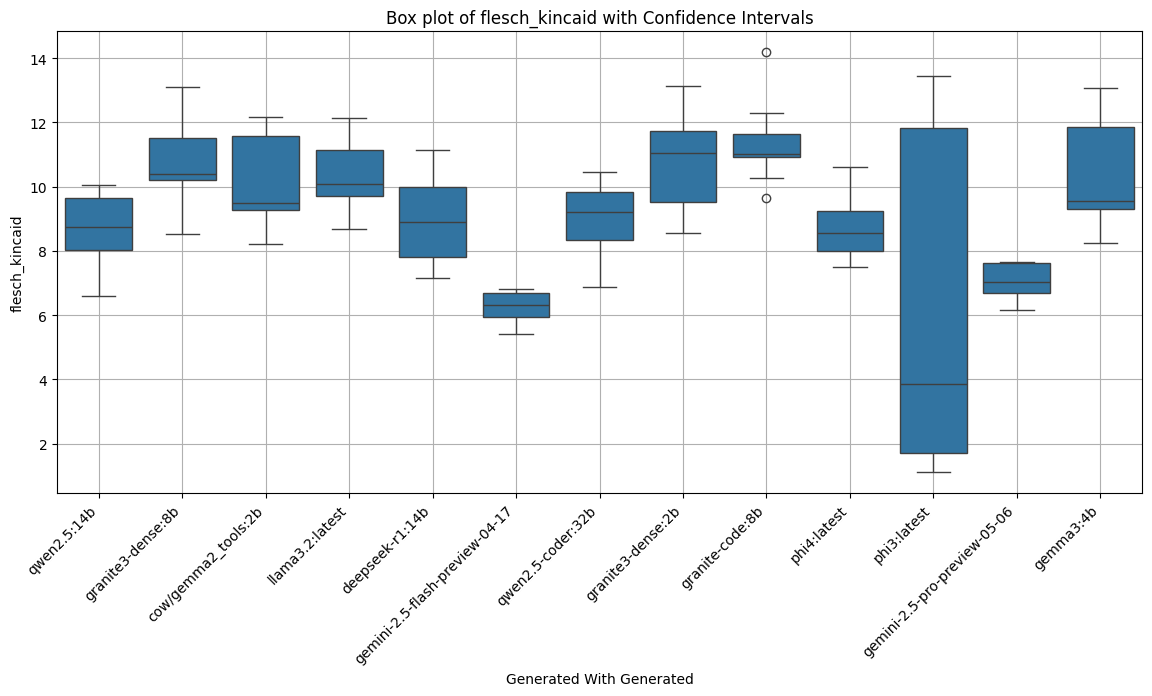

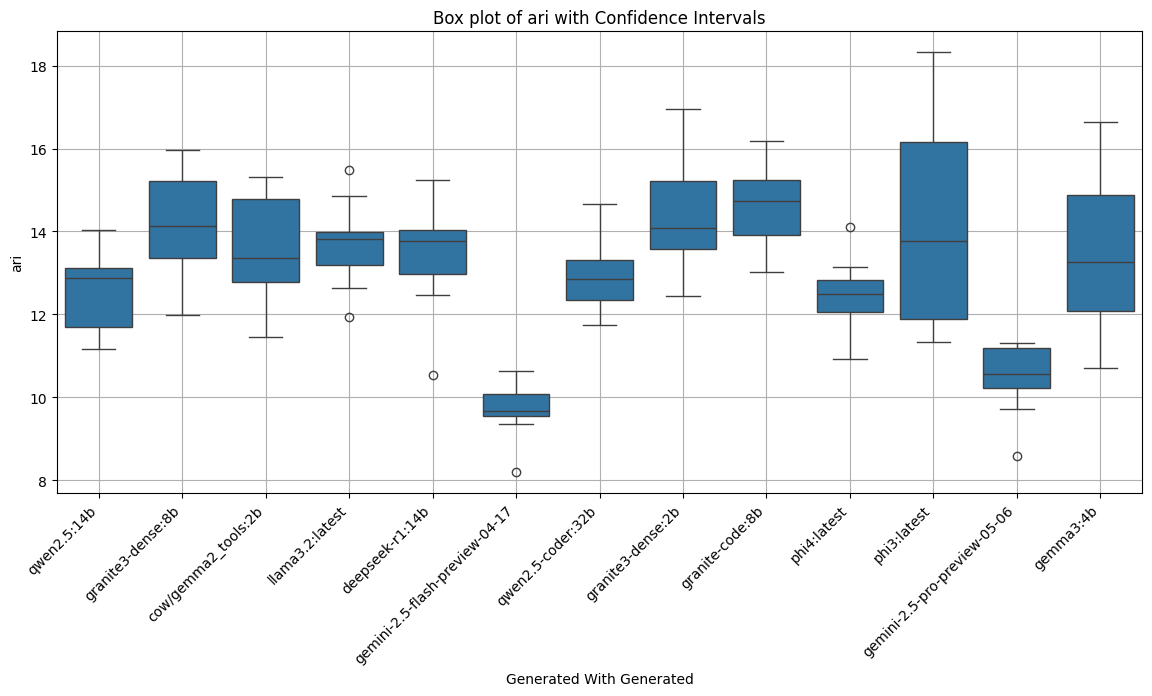

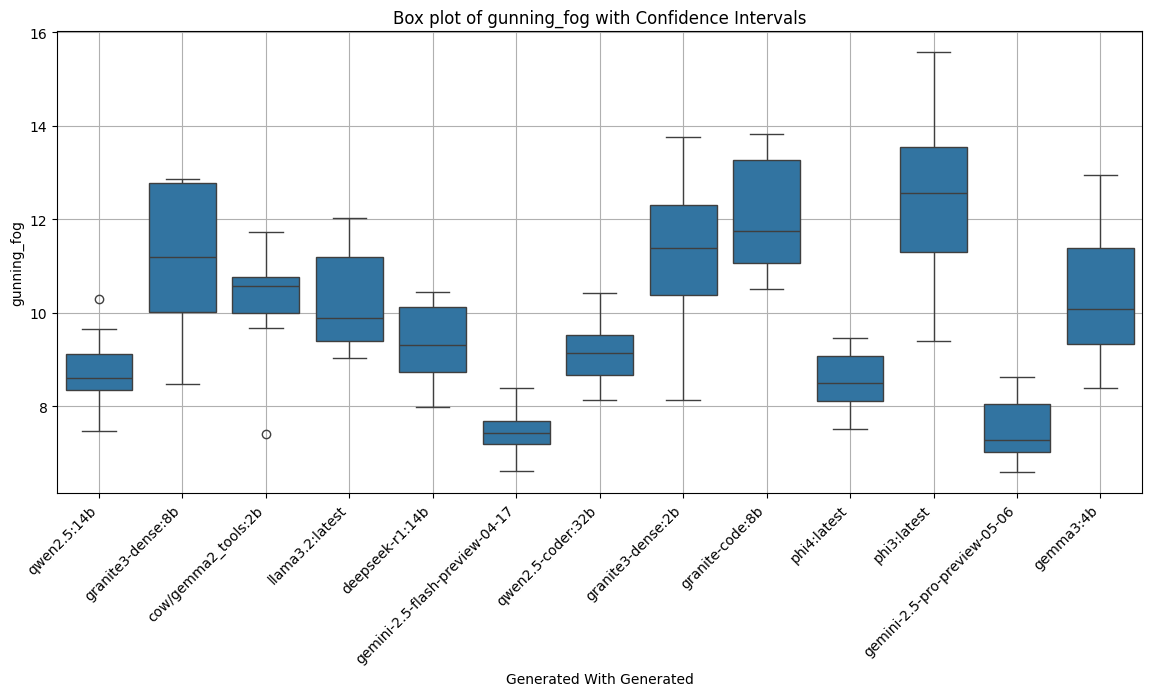

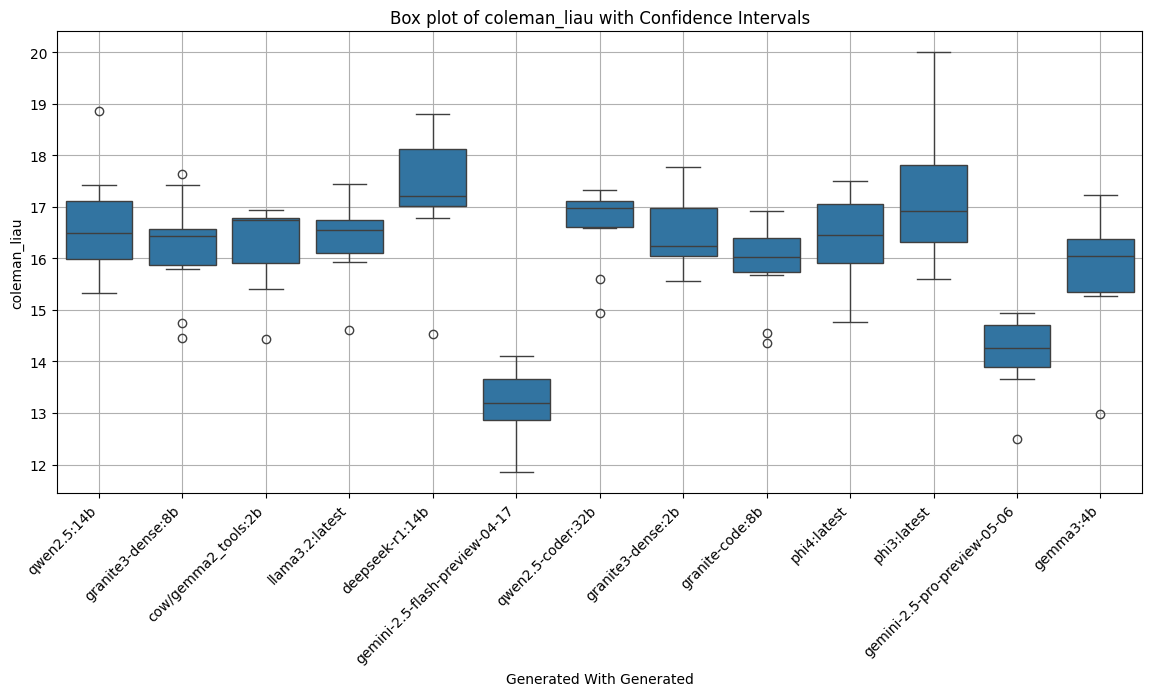

In [17]:
# generate a box plot with the confidence intervals, add a red line for the mean
# using the confidence_intervals dictionary
# each metric should be a separate chart
import matplotlib.pyplot as plt
import seaborn as sns


for metric in grade_level_readability_cols:
    plt.figure(figsize=(14,6))
    sns.boxplot(x="generated_with_generated", y=f"{metric}_generated", data=merged)
    
    for group in merged["generated_with_generated"].unique()+["original"]:
        if (metric,group) in confidence_intervals:
            range_min, mean, range_max = confidence_intervals[metric,group]
            plt.plot([group], [mean], marker='o', markersize=10, color='red')
            plt.vlines(x=group, ymin=range_min, ymax=range_max, color='red', linestyle='--')
    
    plt.title(f'Box plot of {metric} with Confidence Intervals')
    plt.ylabel(metric)
    plt.xlabel('Generated With Generated')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.xticks(fontsize=10)
    plt.show()